In [1]:
version = 5

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

%matplotlib inline

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

In [4]:
records_iq = pd.read_csv(
    './generated/1-features-iq.csv', 
    parse_dates=['week_start_date'],
    index_col='week_start_date'
).interpolate()
records_sj = pd.read_csv(
    './generated/1-features-sj.csv', 
    parse_dates=['week_start_date'],
    index_col='week_start_date'
).interpolate()

In [5]:
labels_iq = pd.read_csv(
    './generated/1-labels-train-iq.csv',
    parse_dates=['week_start_date'],
    index_col='week_start_date'
)
labels_sj = pd.read_csv(
    './generated/1-labels-train-sj.csv',
    parse_dates=['week_start_date'],
    index_col='week_start_date'
)

In [6]:
records_iq['month'] = records_iq['weekofyear']
records_sj['month'] = records_sj['weekofyear']

---

In [7]:
lr_seasonal_sj = LinearRegression()
months_sj = pd.get_dummies(records_sj['month'], prefix='month')
train_months_sj = months_sj[:936].reset_index().drop('week_start_date', axis=1)
test_months_sj = months_sj[936:].reset_index().drop('week_start_date', axis=1)
train_cases_sj = labels_sj[['total_cases']].reset_index().drop('week_start_date', axis=1)

In [8]:
lr_seasonal_sj.fit(train_months_sj, train_cases_sj)
seasonal_sj = pd.Series(
    lr_seasonal_sj.predict(train_months_sj).flatten()).rolling(5, min_periods=1, center=True).mean()
remainder_sj = train_cases_sj.total_cases - seasonal_sj

In [9]:
trend_sj = records_sj[['station_temp']].reset_index().drop('week_start_date', axis=1).rolling(53).mean()
train_trend_sj = trend_sj[53:936]
test_trend_sj = trend_sj[936:]
train_remainder_sj = remainder_sj[53:]

In [10]:
lr_trend_sj = LinearRegression()
lr_trend_sj.fit(train_trend_sj, train_remainder_sj)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [11]:
train_pred_trend_sj = pd.Series(lr_trend_sj.predict(train_trend_sj).flatten())
mean_absolute_error(y_pred=train_pred_trend_sj.values + seasonal_sj[53:].values,
                    y_true=train_cases_sj['total_cases'][53:].values)

25.625392881322803

In [12]:
pred_seasonal_sj = pd.Series(lr_seasonal_sj.predict(test_months_sj).flatten())
pred_trend_sj = pd.Series(lr_trend_sj.predict(test_trend_sj).flatten())

In [13]:
pred_sj = (pred_trend_sj + pred_seasonal_sj).rolling(5, min_periods=1, center=True).mean()

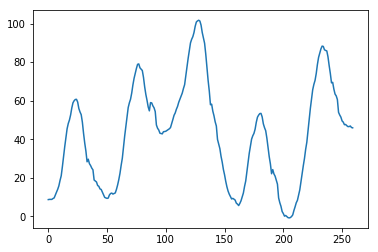

In [14]:
pred_sj.plot()

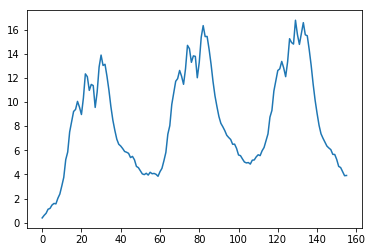

In [15]:
lr_seasonal_iq = LinearRegression()
months_iq = pd.get_dummies(records_iq['month'], prefix='month')
train_months_iq = months_iq[:520].reset_index().drop('week_start_date', axis=1)
test_months_iq = months_iq[520:].reset_index().drop('week_start_date', axis=1)
train_cases_iq = labels_iq[['total_cases']].reset_index().drop('week_start_date', axis=1)

lr_seasonal_iq.fit(train_months_iq, train_cases_iq)
seasonal_iq = pd.Series(
    lr_seasonal_iq.predict(train_months_iq).flatten()).rolling(5, min_periods=1, center=True).mean()
remainder_iq = train_cases_iq.total_cases - seasonal_iq

trend_iq = records_iq[['station_temp']].reset_index().drop('week_start_date', axis=1).rolling(53).mean()
train_trend_iq = trend_iq[53:520]
test_trend_iq = trend_iq[520:]
train_remainder_iq = remainder_iq[53:]

lr_trend_iq = LinearRegression()
lr_trend_iq.fit(train_trend_iq, train_remainder_iq)

pred_seasonal_iq = pd.Series(lr_seasonal_iq.predict(test_months_iq).flatten())
pred_trend_iq = pd.Series(lr_trend_iq.predict(test_trend_iq).flatten())

pred_iq = (pred_trend_iq + pred_seasonal_iq).rolling(5, min_periods=1, center=True).mean()

pred_iq.plot()

In [16]:
pred = pd.concat([pred_sj, pred_iq], ignore_index=True).round()

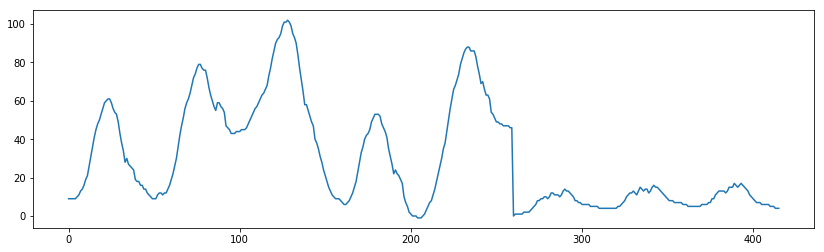

In [17]:
pred.plot(figsize=(14, 4))

In [18]:
pred.to_csv('./generated/2b-seasonal-trend-prediction-' + str(version) + '.csv', index=False)